In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d miadul/prostate-cancer-risk-and-lifestyle-synthetic-dataset


Dataset URL: https://www.kaggle.com/datasets/miadul/prostate-cancer-risk-and-lifestyle-synthetic-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/11.8k [00:00<?, ?B/s]
100% 11.8k/11.8k [00:00<00:00, 41.0MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('prostate-cancer-risk-and-lifestyle-synthetic-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()



# Table of Contents:
  - Intro:
    - 1. Load Data
      - 1,000 individual health profiles focusing on potential risk factors for prostate cancer.
      - This dataset includes a variety of features such as age, body mass index (BMI), smoking habits, diet, physical activity, family history of cancer, mental stress levels, and health-check behavior.
  
    - 2. EDA:
      - Check basic Statistics
      - Identify missig values
      - Visulize Distribution
    
    - 3. Data Preprocessing:
      - Split data: 80% training, 20% Testing
      - Create Process Pipeline
        - Number: Fill missing values with mean -standardize
        - Categorical: Fill missing values with 'most frequent' -OHE

    - 4. Build Model
      - Using Logistic Regression
      - Tuining with GridsearchCV to find best parameters:
        - tested 32 combination
          - 2 numerical
          - 3 categorical
          - 2 fill values
          - 4 Regulariztion strengths
          - Each combination using 10 fold cross validation
    - 5. Results
      - Best Model Achieve:
        - 85.5% Cross Validation Accuracy
        - 87% Test Accuracy
      - Optimal Settings:
        - Mean Impuatation for numbers
        - Most Frequent for missing values
        - Medium regulariztion strength (c=10)
  

# 1. Load Data

In [106]:
# Load Dataset

import pandas as pd
data = pd.read_csv('/content/synthetic_prostate_cancer_risk.csv')
data


,id,age,bmi,smoker,alcohol_consumption,diet_type,physical_activity_level,family_history,mental_stress_level,sleep_hours,regular_health_checkup,prostate_exam_done,risk_level
0,1,39,24.7,No,NaN,Fatty,Moderate,No,High,5.6,No,No,Medium
1,2,43,25.6,Yes,NaN,Mixed,High,No,High,6.9,Yes,No,Low
2,3,72,22.4,No,Moderate,Mixed,Moderate,No,High,7.8,Yes,No,Low
3,4,60,25.6,Yes,NaN,Fatty,Moderate,No,High,5.6,Yes,No,Medium
4,5,51,26.6,Yes,NaN,Mixed,Low,No,Medium,5.9,No,No,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,73,24.5,Yes,Moderate,Healthy,Low,No,Low,5.0,No,No,Medium
996,997,42,25.5,No,NaN,Healthy,Moderate,No,High,8.1,Yes,No,Low
997,998,47,32.4,No,Moderate,Fatty,High,No,Low,7.6,No,No,Low
998,999,54,25.8,No,High,Mixed,Moderate,No,High,6.5,Yes,No,Low


In [107]:
# Descriptive Analysis

data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1000.0,500.5000,288.819436,1.0,250.75,500.5,750.250,1000.0
age,1000.0,55.1590,14.400107,30.0,43.00,55.0,68.000,80.0
bmi,1000.0,26.0031,3.012387,17.7,23.90,26.0,28.025,36.8
sleep_hours,1000.0,6.7255,1.320948,4.5,5.60,6.7,7.900,9.0


In [118]:
# Missing Values
data.isnull().sum()

,0
age,0
bmi,0
smoker,0
alcohol_consumption,395
diet_type,0
physical_activity_level,0
family_history,0
mental_stress_level,0
sleep_hours,0
regular_health_checkup,0


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1000 non-null   int64  
 1   age                      1000 non-null   int64  
 2   bmi                      1000 non-null   float64
 3   smoker                   1000 non-null   object 
 4   alcohol_consumption      605 non-null    object 
 5   diet_type                1000 non-null   object 
 6   physical_activity_level  1000 non-null   object 
 7   family_history           1000 non-null   object 
 8   mental_stress_level      1000 non-null   object 
 9   sleep_hours              1000 non-null   float64
 10  regular_health_checkup   1000 non-null   object 
 11  prostate_exam_done       1000 non-null   object 
 12  risk_level               1000 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 101.7+ KB


In [110]:
data.drop(columns=['id'], inplace=True)
data

,age,bmi,smoker,alcohol_consumption,diet_type,physical_activity_level,family_history,mental_stress_level,sleep_hours,regular_health_checkup,prostate_exam_done,risk_level
0,39,24.7,No,NaN,Fatty,Moderate,No,High,5.6,No,No,Medium
1,43,25.6,Yes,NaN,Mixed,High,No,High,6.9,Yes,No,Low
2,72,22.4,No,Moderate,Mixed,Moderate,No,High,7.8,Yes,No,Low
3,60,25.6,Yes,NaN,Fatty,Moderate,No,High,5.6,Yes,No,Medium
4,51,26.6,Yes,NaN,Mixed,Low,No,Medium,5.9,No,No,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...
995,73,24.5,Yes,Moderate,Healthy,Low,No,Low,5.0,No,No,Medium
996,42,25.5,No,NaN,Healthy,Moderate,No,High,8.1,Yes,No,Low
997,47,32.4,No,Moderate,Fatty,High,No,Low,7.6,No,No,Low
998,54,25.8,No,High,Mixed,Moderate,No,High,6.5,Yes,No,Low


# 2. EDA

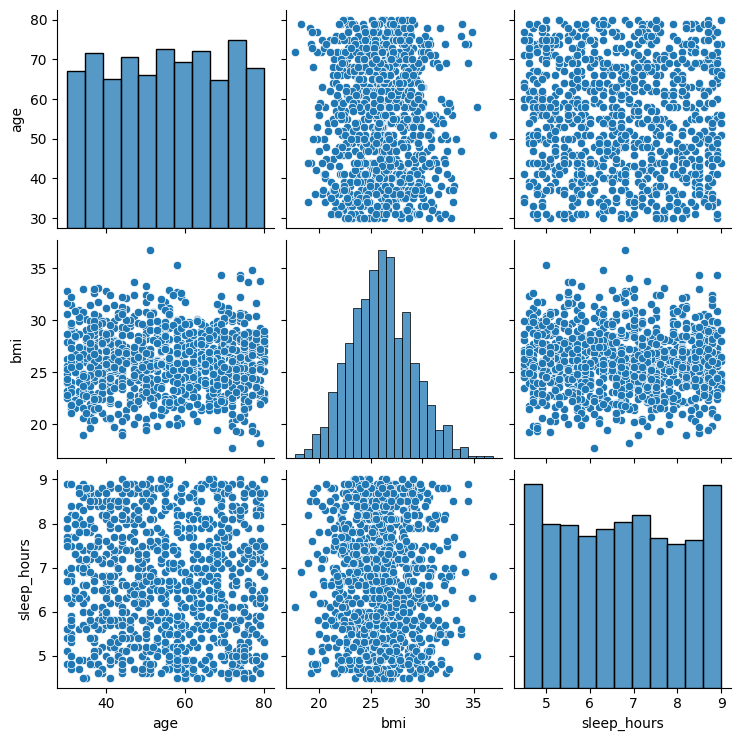

In [111]:
sns.pairplot(data,)

<Axes: xlabel='sleep_hours', ylabel='Count'>

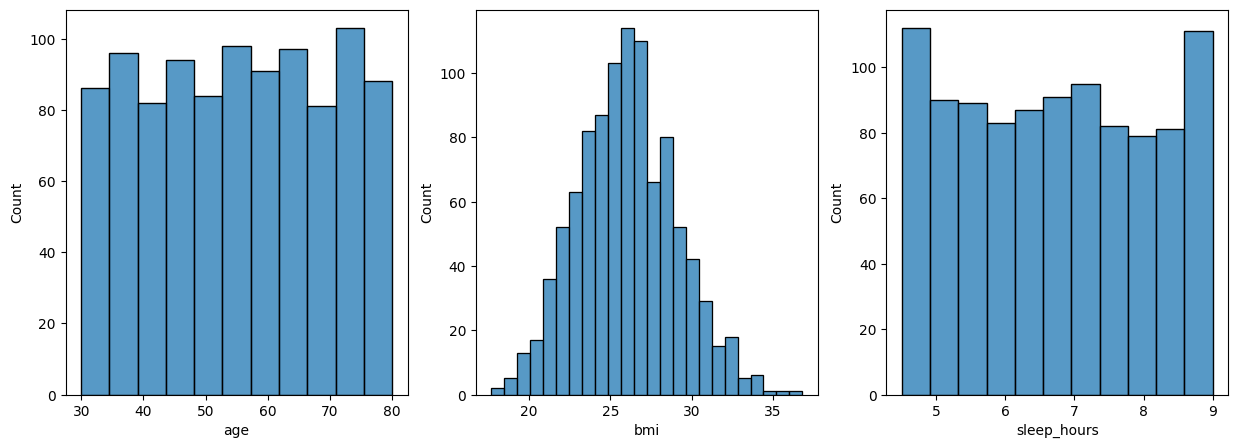

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

plt.subplot(1,3,1)
sns.histplot(data['age'])

plt.subplot(1,3,2)
sns.histplot(data['bmi'])

plt.subplot(1,3,3)
sns.histplot(data['sleep_hours'])


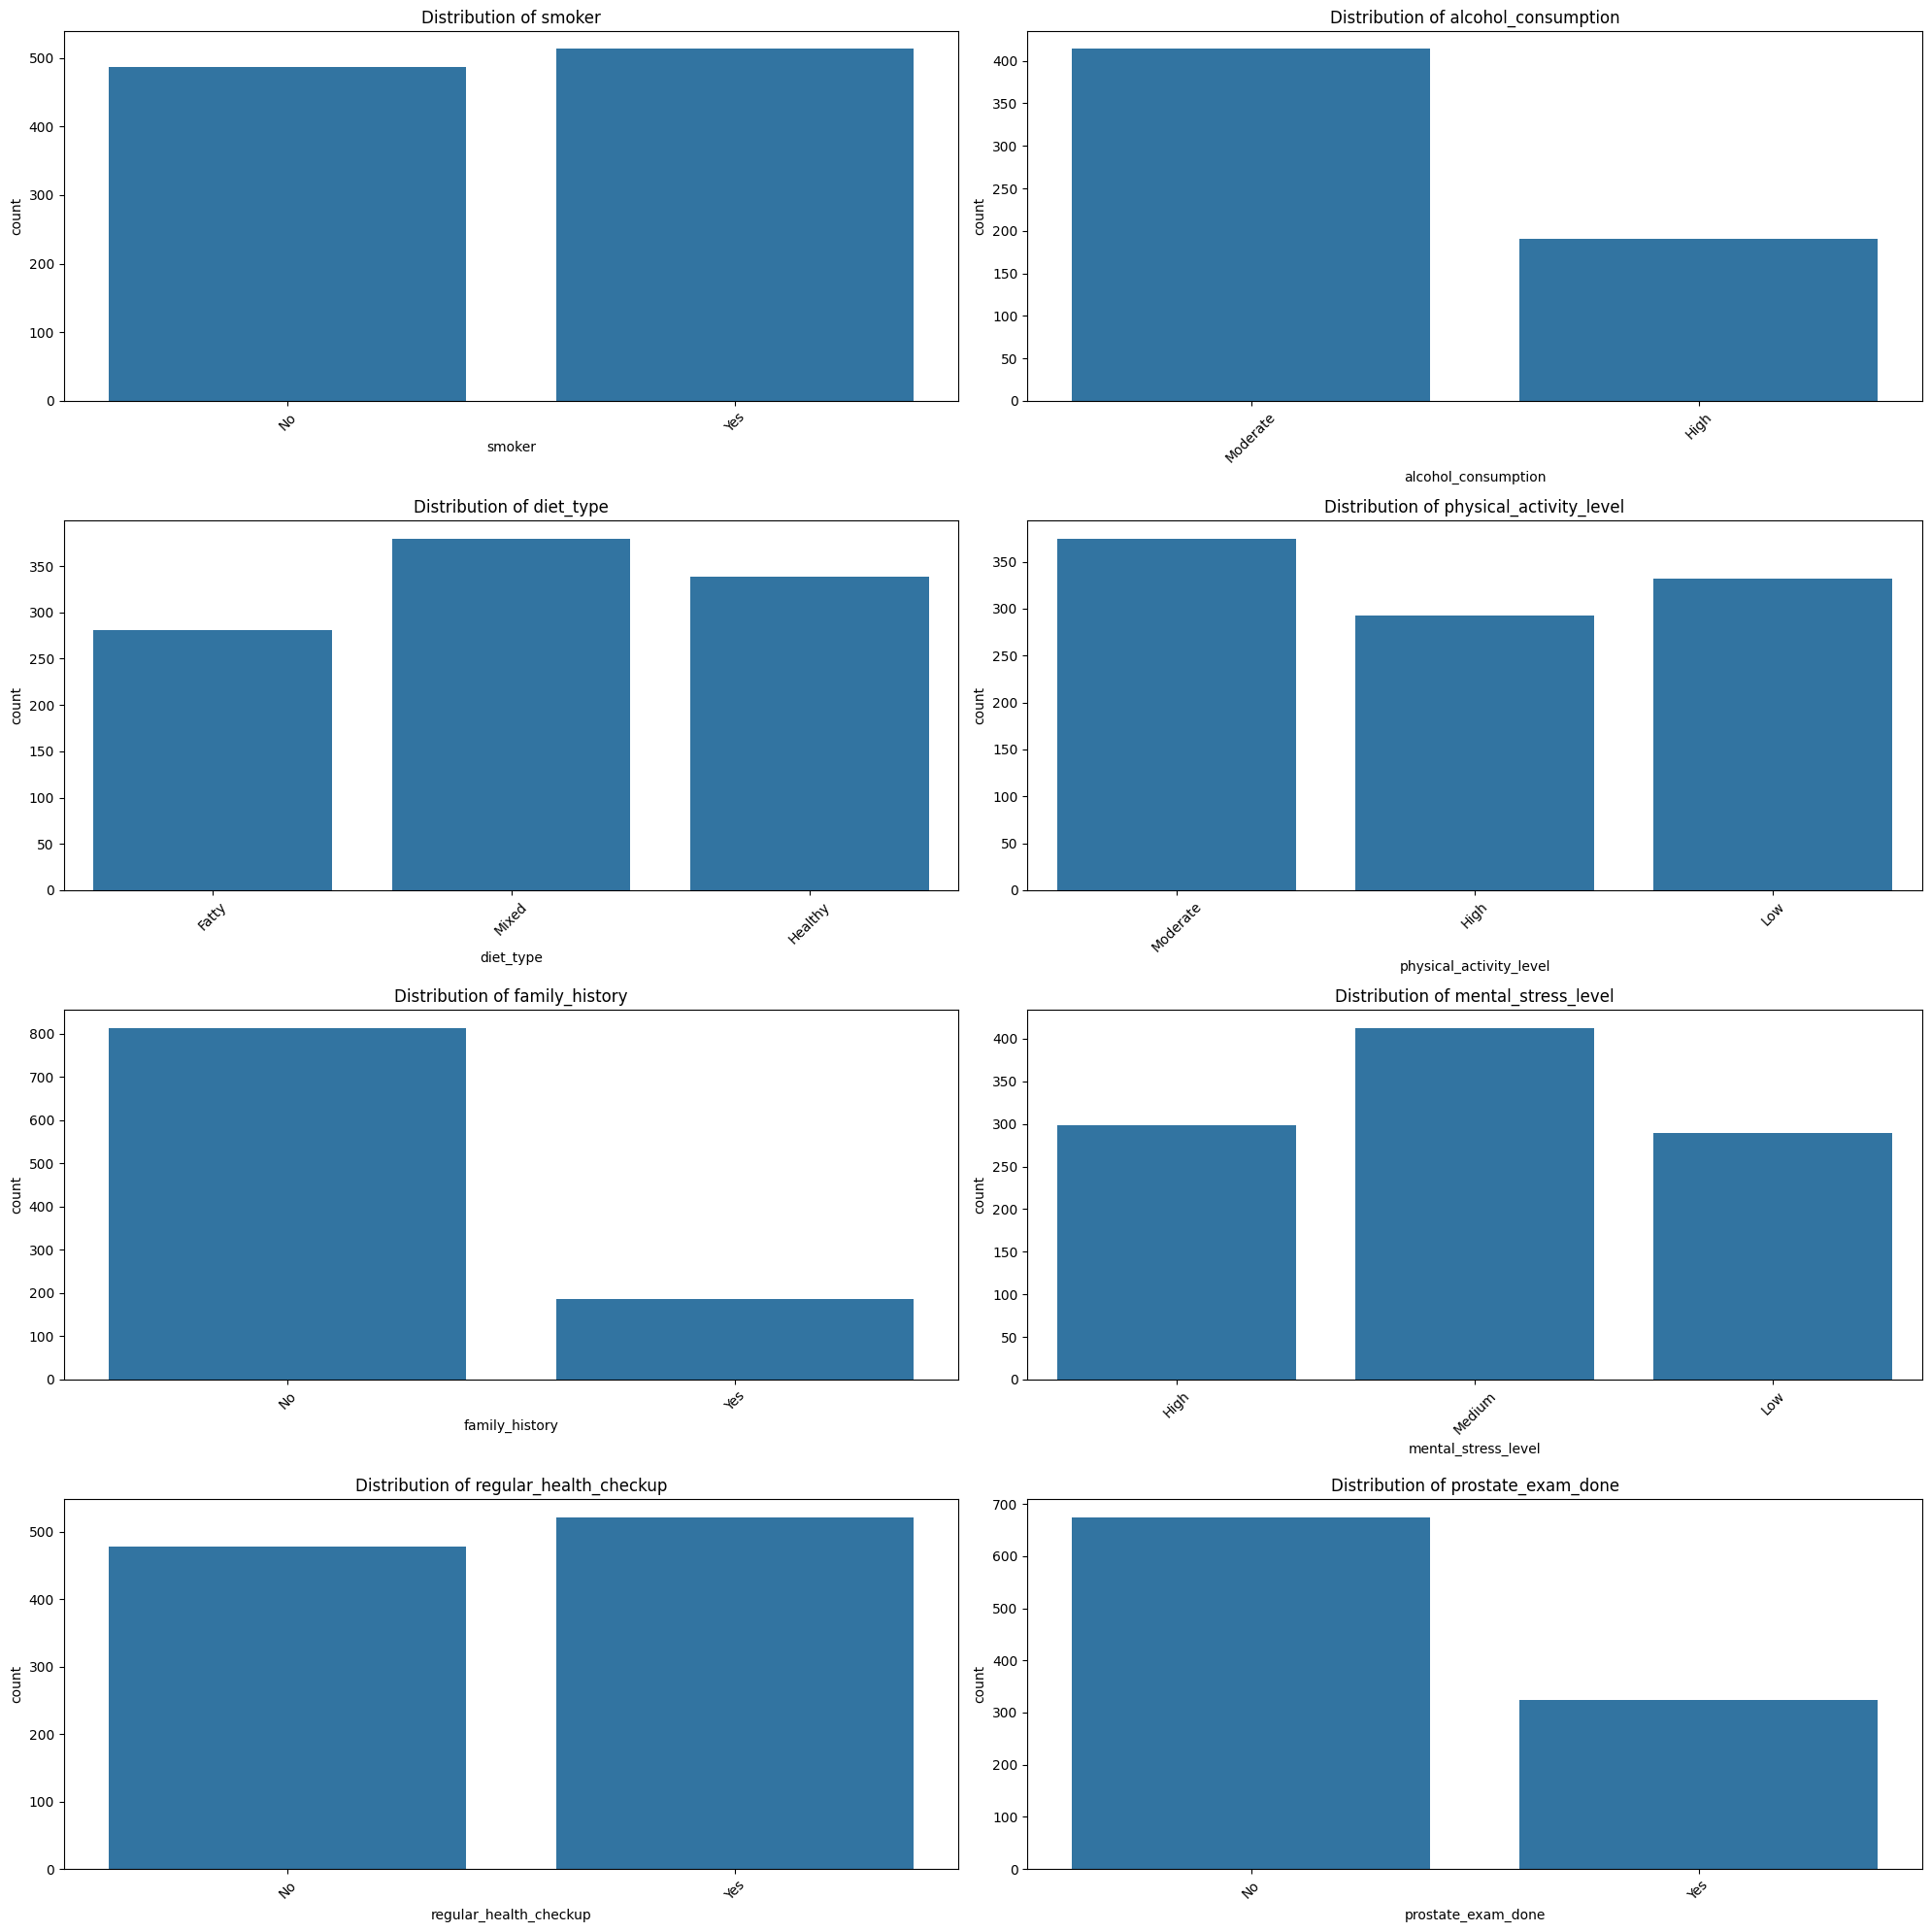

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of categorical columns (adjust as needed)
cat_cols = ['smoker', 'alcohol_consumption', 'diet_type', 'physical_activity_level',
            'family_history', 'mental_stress_level', 'regular_health_checkup', 'prostate_exam_done']

# Create a grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(20, 20))  # 4 rows × 2 cols
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot count plots for each categorical column
for i, col in enumerate(cat_cols):
    sns.countplot(data=data, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-labels

plt.tight_layout()
plt.show()

# 3. Data Preprocessing

In [114]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['risk_level'])
y = data['risk_level']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)


In [115]:
# Create process Pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

numerical_features = ['age', 'bmi', 'sleep_hours']
categorical_features = ['smoker','alcohol_consumption','diet_type',	'physical_activity_level',	'family_history',	'mental_stress_level', 'regular_health_checkup']

# numerical Transformation
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical Transformation
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Strategy will be set via GridSearch
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



# Model Selection

In [116]:
# Build Model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

clf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi',
                                                   'sleep_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['smoker',
                                                   'alcohol_consumption',
                                                   'diet_type',
                                                   'physical_activity_level',
                                                   'family_history',
                                                   'mental_stress_level',
                                                   'regular_health_checkup'])])),
                ('classifier', LogisticRegression())])

# Model Evaluate and Tunning

In [117]:
# Tuining with GridsearchCV

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant'],
    'preprocessor__cat__imputer__fill_value': ['missing', 'Unknown'],
    'classifier__C': [0.1, 1.0, 10, 100],
    'classifier__penalty': ['l2']
}

# Create and fit GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)  # THIS IS THE CRUCIAL MISSING STEP

# Print Best Parameter
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

# Evaluate on test set
test_score = grid_search.score(X_test, y_test)
print("Test set accuracy: {:.3f}".format(test_score))

Fitting 10 folds for each of 32 candidates, totalling 320 fits
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'preprocessor__cat__imputer__fill_value': 'missing', 'preprocessor__cat__imputer__strategy': 'most_frequent', 'preprocessor__num__imputer__strategy': 'mean'}
Best cross-validation score: 0.855
Test set accuracy: 0.870
